In [17]:
import bs4
import calendar
import re
import requests

import numpy as np

import xarray as xr

from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm as TQDM

In [121]:
import matplotlib.pyplot as plt

In [27]:
%matplotlib inline

In [2]:
PARSER = 'lxml-html'

In [3]:
start = 'X-Body-of-Message'
end = 'X-Body-of-Message-End'

In [4]:
yr = 2017
mon = 8

In [5]:
num = 34

In [6]:
MONTH_INDEX_URL_MASK = 'https://www.lists.rdg.ac.uk/archives/met-jobs/{yr}-{mon:02d}/date.html'

In [7]:
MSG_URL_MASK = 'https://www.lists.rdg.ac.uk/archives/met-jobs/{yr}-{mon:02d}/{msg_href}'
# 'https://www.lists.rdg.ac.uk/archives/met-jobs/{yrmon:%Y-%m}/msg{num:05d}.html'

In [8]:
def get_msg_urls(year, month):
    msg_regex = 'msg([0-9]+)\.html'
    index_url = MONTH_INDEX_URL_MASK.format(yr=year, mon=month)
    r = requests.get(index_url)
    hrefs = []
    if r.status_code == 200:
        soup = bs4.BeautifulSoup(r.content, PARSER)
        for i in soup.find_all('a', href=re.compile(msg_regex)):
            hrefs += [i['href']]
    return hrefs

In [9]:
def extract_text_between_comments(soup, comm1, comm2):
    def _extract_text(node):
        return ''.join(t.strip() for t in node(text=True,
                                               recursive=False))
    comm1_tag = soup.find_all(text=comm1)[0]
    comm2_tag = soup.find_all(text=comm2)[0]
    after_comm1 = [*filter(None, [_extract_text(i) for i in comm1_tag.find_all_next()])]
    before_comm2 = [*filter(None, [_extract_text(i) for i in comm2_tag.find_all_previous()])]
    # elements_between = set(a.find_all_next()).intersection(b.find_all_previous())
    text = ''.join([s.strip() for s in after_comm1 if s in before_comm2 and len(s)>1])
    return text

In [10]:
def count_trigger(text, kwd):
    return kwd in text.lower()

In [11]:
year_range = range(2003, 2018)
month_range = range(1, 13)

In [65]:
kwds = ['python',
        'fortran',
        'matlab',
        'javascript',
        'perl',
        'shell',
        'bash',
        'latex',
        'c++',
        'programming',
        'scripting',
        'netcdf',
        'wrf',
        'linux',
        'unix',
        'windows',
        'microsoft']

In [66]:
data = np.zeros((len(year_range), len(kwds)))

In [86]:
result = []
for i, yr in tqdm(enumerate(year_range), desc='Year loop'):
    counts = {k: 0 for k in kwds}
    counts['msg_count'] = 0
    for j, mon in tqdm(enumerate(month_range), desc='Month loop', leave=False):
        hrefs = get_msg_urls(yr, mon)
        for href in tqdm(hrefs, desc='Day loop', leave=False):
            msg_url = MSG_URL_MASK.format(yr=yr, mon=mon, msg_href=href)
            req = requests.get(msg_url)
            if req.status_code == 200:
                counts['msg_count'] += 1
                soup = bs4.BeautifulSoup(req.content, PARSER)
                try:
                    txt = extract_text_between_comments(soup, start, end)
                    for kwd in kwds:
                        if count_trigger(txt, kwd):
                            counts[kwd] += 1
                except:
                    TQDM.write(f'Unable to parse {msg_url}')
            data[i, j] = count
    result.append(counts)

Unable to parse https://www.lists.rdg.ac.uk/archives/met-jobs/2013-01/msg00072.html


Unable to parse https://www.lists.rdg.ac.uk/archives/met-jobs/2013-05/msg00050.html


In [88]:
import pandas as pd

In [148]:
df = pd.DataFrame(result, index=year_range)
df

,bash,c++,fortran,javascript,latex,linux,matlab,microsoft,msg_count,netcdf,perl,programming,python,scripting,shell,unix,windows,wrf
2003,0,5,17,0,0,8,2,1,140,0,4,22,1,1,1,13,4,1
2004,0,8,49,1,0,21,6,3,302,2,3,62,4,3,2,42,3,4
2005,0,14,51,0,0,25,6,10,386,0,8,67,1,4,4,48,4,8
2006,0,13,52,1,0,20,12,11,496,0,7,83,3,4,4,43,3,6
2007,0,9,102,2,0,62,32,13,651,5,9,115,4,7,10,84,6,13
2008,0,20,111,2,0,61,29,15,802,7,8,148,10,12,19,84,12,21
2009,2,13,119,1,1,63,41,18,837,4,8,167,12,20,21,85,6,25
2010,4,38,127,4,0,52,49,17,1012,14,22,165,29,25,27,78,3,32
2011,2,49,150,6,1,55,56,31,1012,16,23,201,34,31,17,102,2,45
2012,3,33,138,5,2,64,60,26,946,24,57,178,42,24,29,94,10,42


In [169]:
languages = ['bash', 'c++', 'fortran', 'javascript', 'matlab', 'perl', 'python', 'shell']

In [149]:
df['weights'] = df.msg_count.max() / df.msg_count

In [142]:
pure_df = df[[i for i in df.columns if i != 'msg_count' and i != 'weights']]

In [143]:
weigthed_by_msg_count = pure_df.multiply(df.weights, axis=0)

In [171]:
lang_df = weigthed_by_msg_count[languages]
lang_df = lang_df.multiply(1 / lang_df.sum(axis=1), axis=0)

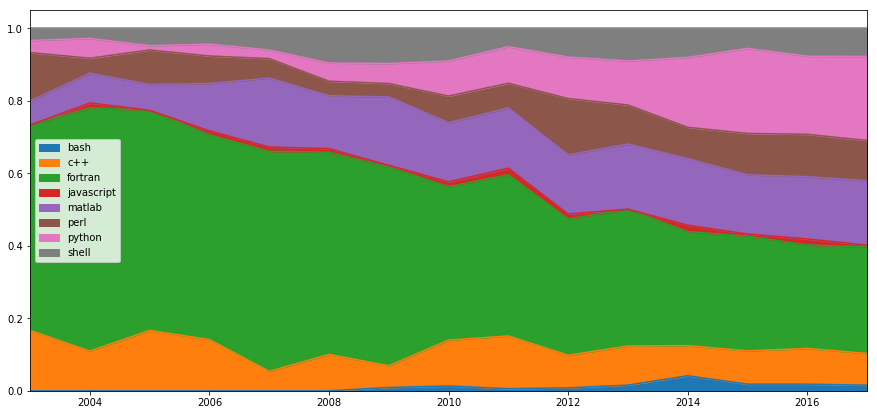

In [174]:
fig, ax = plt.subplots(figsize=(15, 7))
lang_df.plot.area(ax=ax)